# Twitter y Bitcoin: Dos mundos conectados ¿o no?

Librerias para correr el codigo minimo:

- sklearn
- requests
- pandas
- matplotlib
- numpy
- seaborn

Requerimientos para correr todo el codigo:

1) Librerias
- Librerias para correr el codigo minimo
- selenium
- nest_asyncio
2) Archivos/Programas
- Chrome
- Chromedriver apropiado para tu versión de chrome en el mismo directorio que este jupyter (descargas: https://chromedriver.chromium.org/home)
- secret.py

secret.py debe contener 2 variables (En caso de querer correr todo el codigo):
```
sentiment_key = "<Tu API_key de deepai.org>"
bearer_token = "<Tu bearer_token de tweeter>"
```

### Introducción

Contexto: Luego de la publicación de un tweet hecho por Elon Musk en Mayo (https://twitter.com/elonmusk/status/1392602041025843203?ref_src=twsrc%5Etfw%7Ctwcamp%5Etweetembed%7Ctwterm%5E1392602041025843203%7Ctwgr%5E%7Ctwcon%5Es1_&ref_url=https%3A%2F%2Fwww.bbc.com%2Fmundo%2Fnoticias-57096818)
Bitcoin tuvo una de sus primeras caídas fuertes luego de mucho tiempo. Producto de esto nosotros nos preguntamos ¿Existió relación entre la connotación de dicho tweet y la caída que tuvo el bitcoin?

-NOTA: Nuestros objetivos de la propuesta han cambiado solamente de modo que en vez de trabajar sobre noticias de blogs, trabajamos sobre Tweets-

Objetivos: Saber si las noticias afectan al valor del bitcoin.

-NOTA: Hemos modificado totalmente 2 preguntas, ya que nos dimos cuenta que el incluir "cuenta más importante de twitter" es algo muy subjetivo y además esto fue gracias a la página https://criptotendencia.com/2018/07/12/los-tweets-influyen-en-el-precio-de-bitcoin/ Donde se habla de una investigación similar a la nuestra y destaca que mientras más cantidad de tweets hablando sobre bitcoin, mayor es el valor que tiene y así-

Preguntas de Investigación: ¿Qué relación tiene la connotación de la noticia con el valor del Bitcoin?, ¿En cuánto influye la popularidad de la cuenta creadora del tweet con la caída/subida del valor de Bitcoin?, ¿Qué relación existe entre la cantidad de tweets hablando sobre bitcoin con alguna caída del valor del bitcoin?, ¿Qué relación existe entre la cantidad de tweets hablando sobre bitcoin con alguna subida del valor del bitcoin?, ¿Si el valor del Bitcoin varía su valor con las noticias y 
sucesos ajenos a él, es una inversión segura en este sentido?.


### Imports

In [1]:
import requests
import sklearn
from datetime import datetime, timedelta
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import secret
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import time
import os

try:
    import nest_asyncio
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.common.by import By
    from selenium.webdriver.common.keys import Keys
except Exception as e:
    print(e)
    print("No se pudo importar un requerimiento del scrapper. No vas a poder usarlo")

### 1) Twitter scrapping

**Mas abajo cargamos los tweets desde data/tweets.csv, por lo que no es necesario correr esta parte más que para probarla**

Para correr esta parte necesitas:

- Tener Chrome instalado
- Tener chromedriver apropiado para tu versión de chrome el mismo directorio que este jupyter (descargas: https://chromedriver.chromium.org/home)

Si tu sistema operativo no es windows, posiblemente debas hacer cambios en los argumentos de chrome_options para correr el scrapper

In [2]:
nest_asyncio.apply()

chrome_options = Options()
chrome_options.add_argument("--headless")
driver = webdriver.Chrome(executable_path=os.path.abspath("chromedriver"), chrome_options=chrome_options)

In [3]:
driver.get("https://twitter.com/search?q=bitcoin&src=typed_query")

El siguiente codigo se va a tomar bastante tiempo, ya que literalmente tiene que navegar por twitter en un browser oculto (Más adelante cargamos un archivo con los resultados de correr el scrapper por varios días. Por lo que no es necesario más que para probarlo)

In [4]:
def get_articles():
    articles = []
    for _ in range(100):
        try:
            el = driver.find_elements(By.TAG_NAME, "article")

            html = driver.find_element(By.TAG_NAME, 'html')

            my = []
            for e in el:
                article = e.text.split("\n")
                if article[-1] == "Show this thread":
                    article[-1] = ""
                publisher = (article[0], article[1])
                date = e.find_element(By.TAG_NAME, "time").get_attribute("datetime")
                date = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.000Z')
                article = [x for x in article if len(x) >= 5]
                pub = ('\n'.join([at for at in article[4:] if
                                  at.strip('\t').strip(' ') != "" and not at.strip('\t').strip(' ').isdigit()])).replace(
                    '.\n', '. ').replace('\n', '. ')

                if len(list(filter(lambda x: x[0] == publisher and x[1] == date and x[2] == pub, articles))) == 0:
                    articles.append((publisher, date, pub))
                    print(len(articles))

            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.3)
            e.send_keys(Keys.PAGE_DOWN)
            time.sleep(0.28)
            e.send_keys(Keys.PAGE_DOWN)

            time.sleep(0.5)
        except Exception as e:
            print("ERROR: ",e)
    return articles


articles = get_articles()

1
2
3
4


KeyboardInterrupt: 

In [5]:
#publisher_names = [article[0][0] for article in articles]
publisher_ids = [article[0][1][1:] for article in articles]
publisher_tweet_dates = [article[1].timestamp() for article in articles]
publisher_tweets = [article[2] for article in articles]

conv = zip(publisher_ids, publisher_tweet_dates, publisher_tweets)

df = pd.DataFrame(list(conv), columns=['p_id', 'date', 'tweet'])

NameError: name 'articles' is not defined

Ahora cargemos lo que previamente teniamos en tweets.csv (No usar si no se corrió el scrapper)

In [6]:
if os.path.isfile("data/tweets.csv"):
    old_tweets = pd.read_csv("data/tweets.csv")
    df = df.append(old_tweets)
    df = df.drop_duplicates()

NameError: name 'df' is not defined

Convertir los tweets y guardarlos para el futuro (Solo si se corrió el codigo)

In [7]:
df.to_csv("data/tweets.csv")
df.head()

NameError: name 'df' is not defined

Cargar los tweets (Usar si no se corrio el scrapper)

In [8]:
df = pd.read_csv("data/tweets.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

### 2) DataCleanup

Eliminar las filas en donde el tweet está vacío

In [9]:
p_len = len(df)
df['tweet'].replace('', np.nan, inplace=True)
df.dropna(inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

6 tweets eliminado(s)! (24877 restantes)


Eliminar las filas donde el tweet tiene menos de 188 characteres, para solo tener los tweets donde el texto es importante (no solo los archivos como imagenes o videos)

El 188 fue elegido ya que el promedio de characteres de una palabra en inglés (Estamos tomando los tweets en inglés ya que son los más influenciadores) es 4.7, por lo tanto si queremos 40 palablas minimo, usamos 188. (Elegimos 40 palabras para bajar la cantidad de tweets y no perder tanto tiempo en el sentiment analysis, pero nos habría gustado usar entre 10-20)

In [10]:
p_len = len(df)
df = df[df['tweet'].str.len() > 188]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

16300 tweets eliminado(s)! (8577 restantes)


Eliminar usernames con espacios

In [11]:
p_len = len(df)
df = df[~(df['p_id'].str.contains(" "))]
df['p_id'].replace('', np.nan, inplace=True)
df.dropna(subset=['p_id'], inplace=True)
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

1 tweets eliminado(s)! (8576 restantes)


In [12]:
df["p_id"].unique()

array(['DeAiDave', 'TuurDemeester', '5Bilionsales', ..., 'BondsCharts',
       'ChefGruel', 'tuihane_'], dtype=object)

### 3) Get user data with the twitter api

**Se nesesita tener el bearer_token en secret.py** Más adelante cargamos data que ya pasamos por el api para no tener que hacer este paso

Con los tweets no utiles removidos del dataframe, ahora podemos ir a twitter a buscar la data de los usuarios restantes sin tener que hacer un request más largo al api, para después igual eliminar esos usuarios

In [13]:
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {secret.bearer_token}"
    r.headers["User-Agent"] = "v2UserLookupPython"
    return r


def get_users(users_list):
    usernames = f"usernames={','.join(users_list)}"
    user_fields = "user.fields=public_metrics,verified"
    url = "https://api.twitter.com/2/users/by?{}&{}".format(usernames, user_fields)
    response = requests.request("GET", url, auth=bearer_oauth, )
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


# Only 300-requests/15-min to not be banned
users_list = list(set([user for user in df["p_id"]]))

print(f"{len(users_list)} unique users")

json_response = []
for i in range(0, len(users_list), 100):
    usrs = users_list[i:i + 100]
    print(f"Getting {i+100}/{len(users_list)} users\r", end="")
    n_u = get_users(usrs)["data"]
    json_response.extend(n_u)
print("Done!"+" "*20)

2622 unique users


KeyboardInterrupt: 

Crear el dataframe con los usuarios (No correr si no se corrió el codigo anterior)

In [14]:
usernames = []
followers = []
following = []
listed_count = []
tweet_count = []
verified = []

u_ids = df["p_id"].unique()
for usr in json_response:
    if usr["username"] not in u_ids:
        continue
    usernames.append(usr["username"])
    followers.append(usr["public_metrics"]["followers_count"])
    following.append(usr["public_metrics"]["following_count"])
    listed_count.append(usr["public_metrics"]["listed_count"])
    tweet_count.append(usr["public_metrics"]["tweet_count"])
    verified.append(int(usr["verified"]))

df_users = pd.DataFrame(zip(usernames, followers, following, listed_count, tweet_count, verified),
                        columns=['username', 'followers', 'following', 'listed count', 'tweet count', 'verified'])
df_users

,username,followers,following,listed count,tweet count,verified
0,spurtmagoo,17853,913,32,42468,0
1,NftAvax,1627,338,0,328,0
2,EMPOWR_us,2927,152,14,377,0
3,CryptoGambleTip,7345,291,2,387,0
4,Psolemn,326721,687,187,51863,0
...,...,...,...,...,...,...
195,ShibReports,193664,2361,337,1458,0
196,plebsmemes,1213,1246,9,1637,0
197,edugaresp,79735,1930,796,49388,1
198,manotelli,47287,627,132,73182,0


### 4) Data cleanup (Parte 2)
separamos el datacleanup en 2, para poder usar el API de twitter la cantidad de veces que realmente se necesitan


Eliminar los usuarios que tienen pocos seguidores:

In [16]:
p_len = len(df_users)
df_users = df_users[df_users['followers'] > 150000]
df_users.head()
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")

0 usuarios eliminado(s)! (608 restantes)


Eliminar usuarios con similar cantidad de followers que following o incluso menor followers que following (Muchos tienen seguidores porque siguen de regreso y no tienen mucho valor en este proyecto)

En este caso, la diferencia entre los followers y following, deben ser mayores a el 80% de la suma de estos (Esto es para disminuir el volumen de datos para no utilizar tanto tiempo en el sentiment analysis. Si el tiempo no fuera un problema, sería mejor bajar el porcentaje a 50%)

In [17]:
p_len = len(df_users)
df_users = df_users[df_users['followers']-df_users['following'] > (df_users['followers']+df_users['following'])*0.8]
print(f"{p_len-len(df_users)} usuarios eliminado(s)! ({len(df_users)} restantes)")
df_users

0 usuarios eliminado(s)! (608 restantes)


,Unnamed: 0,username,followers,following,listed count,tweet count,verified
0,3,peterhuntcrypto,151121,7463,57,9726,0
1,8,rssurjewala,1727123,151,798,14742,1
2,11,goto_nikkei,285278,162,3242,3285,1
3,14,DrogCrypto,201501,362,527,18604,0
4,18,NewYorker,8994296,399,64198,131339,1
...,...,...,...,...,...,...,...
603,1859,shl,264192,24,4070,27785,1
604,1863,itsALLrisky,238236,507,414,14530,0
605,1866,garciabanchs,358529,2032,2042,137238,1
606,1869,Crypto_Hawkk,392934,69,320,908,0


Ahora, borramos los tweets de los usuarios que fueron eliminados

In [18]:
p_len = len(df)
df = df[df['p_id'].isin(df_users["username"])]
print(f"{p_len-len(df)} tweets eliminado(s)! ({len(df)} restantes)")

3762 tweets eliminado(s)! (4814 restantes)


Guardar los usuarios (Solo si se corrió el codigo para descargar los usuarios)

In [ ]:
df_users.to_csv("data/users.csv")

Cargar los usuarios previamente creados (En caso de no haber corrido la descarga de usuarios por el API)

In [19]:
df_users = pd.read_csv("data/users.csv")
df_users = df_users.loc[:, ~df_users.columns.str.contains('^Unnamed')]

### 5) Sentiment analysis
Usamos deepai.org, por lo que necesitas una cuenta y **tienes que colocar sentiment_key en secret.py si quieres correr este segmento** (Más adelante cargamos un archivo con los resultados para los tweets. Por lo que no es necesario más que para probar el codigo)


Ahora que tenemos la data como queremos, podemos empezar a identificar el sentimiento de los tweets que quedan, para luego hacer regression para saber cuanto puede un usuario afectar los tweets, luego hacer k-cluster para saber los datos más importantes. (Solo correr si se tiene el api key de deepai.org y 2+ horas disponibles)

In [20]:
tweet_neg = []
tweet_neu = []
tweet_pos = []
tweet_vpos = []
tweet_vneg = []

tweet_beg = []
tweet_end = []

for t_id, tweet in enumerate(df["tweet"]):
    print(f"{t_id + 1}/{len(df['tweet'])}\r", end="")

    for error_n in range(50):
        try:
            r = requests.post(
                "https://api.deepai.org/api/sentiment-analysis",
                data={
                    'text': tweet,
                },
                headers={'api-key': secret.sentiment_key}
            )
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(10+error_n)
    for error_n in range(10):
        try:
            phrases = r.json()["output"]
            break
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(1)
    if error_n == 9:
        print("Could not solve!")
        continue

    tweet_beg.append(phrases[0])
    tweet_end.append(phrases[-1])
    phs_vneg = 0
    phs_neg = 0
    phs_neu = 0
    phs_pos = 0
    phs_vpos = 0
    for ph in phrases:
        phs_vneg += ph == "Verynegative"
        phs_neg += ph == "Negative"
        phs_neu += ph == "Neutral"
        phs_pos += ph == "Positive"
        phs_vpos += ph == "Verypositive"
        if ph not in ["Verynegative", "Negative", "Neutral", "Positive", "Verypositive"]:
            print(f"New state found'{ph}'")
    tweet_vneg.append(phs_vneg)
    tweet_neg.append(phs_neg)
    tweet_neu.append(phs_neu)
    tweet_pos.append(phs_pos)
    tweet_vpos.append(phs_vpos)

print("Done!" + " "*20)

KeyboardInterrupt: 

Agregar los nuevos datos a el dataframe de tweets

In [21]:
df['sentiment_begin'] = tweet_beg
df['sentiment_end'] = tweet_end

df['sentiment_very_positive'] = tweet_vpos
df['sentiment_positive'] = tweet_pos
df['sentiment_neutral'] = tweet_neu
df['sentiment_negative'] = tweet_neg
df['sentiment_very_negative'] = tweet_vneg

df

ValueError: Length of values (0) does not match length of index (4814)

Cargar los tweets con sentiment analysis (Correr si no se usó el sentiment analysis de los 2 bloques anteriores)

In [22]:
df = pd.read_csv("data/tweet_sentiment.csv")

Ahora podemos revisar algunos de los tweets para saber si son clasificados correctamente

In [23]:
df[df["sentiment_positive"] > df["sentiment_negative"]].head()

,Unnamed: 0,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative
6,219,saylor,1.639328e+09,#Bitcoin is growing stronger behind a wall of ...,Positive,Neutral,0,3,4,0,0
55,527,CryptoWhale,1.639153e+09,The U.S. Bureau of Labor revealed today that I...,Positive,Neutral,1,1,4,0,0
73,625,LayahHeilpern,1.639088e+09,Really great to interview Mayor @FrancisSuarez...,Positive,Neutral,1,1,5,0,0
75,628,JonErlichman,1.639086e+09,"10-year returns. . Bitcoin: +1,607,250....",Positive,Neutral,0,1,14,0,0
92,773,TheCryptoLark,1.639018e+09,Why does Fidelity have to go to Canada to laun...,Negative,Neutral,0,2,6,1,0


In [24]:
print(f"Existen {len(df[df['sentiment_very_positive'] > 0]):04} tweets con sentiment_very_positive. Generando {np.sum(df['sentiment_very_positive']):05} frases sentiment_very_positive.")

print(f"Existen {len(df[df['sentiment_positive'] > 0]):04} tweets con sentiment_positive.      Generando {np.sum(df['sentiment_positive']):05} frases sentiment_positive.")

print(f"Existen {len(df[df['sentiment_neutral'] > 0]):04} tweets con sentiment_neutral.       Generando {np.sum(df['sentiment_neutral']):05} frases sentiment_neutral.")

print(f"Existen {len(df[df['sentiment_negative'] > 0]):04} tweets con sentiment_negative.      Generando {np.sum(df['sentiment_negative']):05} frases sentiment_negative.")

print(f"Existen {len(df[df['sentiment_very_negative'] > 0]):04} tweets con sentiment_very_negative. Generando {np.sum(df['sentiment_very_negative']):05} frases sentiment_very_negative.")


#np.sum(df["sentiment_positive"])
#len(df[df["sentiment_positive"] > 0])

Existen 0047 tweets con sentiment_very_positive. Generando 00047 frases sentiment_very_positive.
Existen 1438 tweets con sentiment_positive.      Generando 01816 frases sentiment_positive.
Existen 4413 tweets con sentiment_neutral.       Generando 18365 frases sentiment_neutral.
Existen 4522 tweets con sentiment_negative.      Generando 10290 frases sentiment_negative.
Existen 0114 tweets con sentiment_very_negative. Generando 00116 frases sentiment_very_negative.


In [25]:
df[df["sentiment_very_positive"] > 0].head()["tweet"]

55     The U.S. Bureau of Labor revealed today that I...
73     Really great to interview Mayor @FrancisSuarez...
523    Wow. . The City of Miami just announced they a...
655    El Salvador made Bitcoin legal tender 54 days ...
718    @elonmusk @Filasophical @ShibaInuHodler #Bitco...
Name: tweet, dtype: object

In [26]:
df[df["sentiment_very_negative"] > 0].head()[["tweet", "sentiment_begin", "p_id"]]

,tweet,sentiment_begin,p_id
4,"According to sources, the Ministry of Electron...",Negative,OpIndia_com
69,#ElEconomista | El presidente de Costa Rica an...,Verynegative,prensagrafica
123,Bears repeating: When I met Vitalik in 2012 an...,Verynegative,maxkeiser
259,"Dice el prófugo, referente de la oposición y a...",Verynegative,nayibbukele
303,Los mismos boomers que se comieron las prefere...,Verynegative,wallstwolverine


Lo anterior, demuestra que, aunque no son perfectas, las clasificaciónes son bastante buenas
Por ejemplo el tweet de PresidenciaSV, la primera frase "*“Por alguna razón estamos reunidos aquí, en la playa Mizata, en El Salvador, divirtiéndonos y mirando hacia el futuro”, Presidente @nayibbukele*" fue clasificado como super negativo. Como no podemos analizar todos los tweets para saber si fueron correctamente clasificados, no hay mucho que podamos hacer al respecto, pero tenemos que tener claro que las concluciónes pueden no ser tan certeras como quisieramos.

Lo unico que nos queda por cargar son los valores del Bitcoin. Estos se consiguieron por scrapping de CoinMarketCap. Pero prefiero no publicar el codigo utilizado, por miedo a que arreglen el bug que permite esta recoleción de datos

In [27]:
df_btc = pd.read_csv("data/btc_values.csv")
df_btc.sample(n=5)

,timestamp,price
21822,1632895442,42300.631882
49440,1624624743,33130.782121
65763,1619858943,57516.265681
50626,1624298043,32221.898501
75498,1616938443,55982.116729


El dataframe de precios, está compuesto de 2 columnas, timestamp y price donde timestamp es la fecha en formato unix timestamp

Ahora podemos hacer una grafico para hacernos una idea de lo que tenemos que hacer

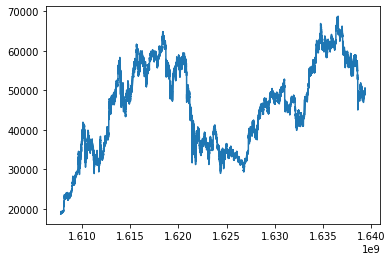

In [28]:
fig = plt.plot('timestamp', 'price', data=df_btc)

Ahora decidimos que el maximo de tiempo que vamos a predecir, es 7 días. Por lo que debemos eliminar los tweets más recientes que no tienen valores en "data/btc_values.csv" 7 días después de su publicación (La idea habría sido definirlos al principio, para no tener que conseguir el sentiment analysis de estos y también bajar la cantidad de usos de la API de twitter. Pero no tenemos el tiempo para volver a correr el sentiment analysis. Aunque la posicion de este cleanup **no** tiene efecto sobre el resultado final)

In [29]:
day_7 = 7*24*60*60

p_len = len(df)
df = df[df["date"]+day_7 < np.max(df_btc['timestamp'])]
df = df.reset_index(drop=True)
print(f"{p_len-len(df)} tweets eliminados ({len(df)} restantes)")

173 tweets eliminados (4641 restantes)


Ahora como ejemplo, mostremos un tweet en el grafico anterior


1. encontremos los extremos temporales de los tweets, para no tener que mostrar todo el historial que tenemos disponible

In [30]:
max = np.max(df['date']) + day_7
min = np.min(df['date'])

def get_price_near(timestamp):
    return df_btc.iloc[(df_btc['timestamp']-timestamp).abs().argsort()].iloc[0]["price"]


In [31]:
p_len = len(df_btc)
df_btc = df_btc[df_btc["timestamp"] > min]
df_btc = df_btc[df_btc["timestamp"] < max]
print(f"{p_len-len(df_btc)} fechas eliminadas ({len(df_btc)} restantes)")

5471 fechas eliminadas (100422 restantes)


2. Encontremoas el tweet al azar y mostremoslo en el grafico (tweet 8)

1638731209.0 49076.49230245249


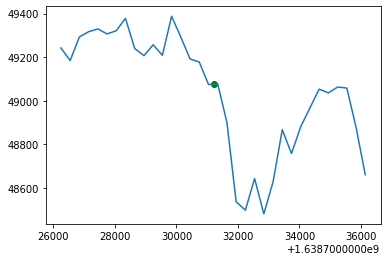

In [32]:
tweet_date = df.iloc[8]['date']

df_btc_short = df_btc[df_btc["timestamp"] > tweet_date-5000]
df_btc_short = df_btc_short[df_btc_short["timestamp"] < tweet_date+5000]

print(tweet_date, get_price_near(tweet_date))

fig = plt.plot('timestamp', 'price', data=df_btc_short)
plt.scatter(tweet_date, get_price_near(tweet_date), color='green')

Nos podemos dar cuenta de que nos estamos acercando a nuestro objetivo, ahora hay que ver "cuanto" cambia el precio del bitcoin después de cada tweet

Para esto, vamos a crear 6 nuevas columnas a los tweets: Los deltas de los precios después de 5 min, 30 min, 1h, 5h, 1d, 7d

In [33]:
min_5 = 5*60
min_30 = 30*60
hour_1 = 60*60
hour_5 = 5*hour_1
day_1= 24*hour_1
# day_7 is already defined

# def date_func(row):
#     now_price = get_price_near(row["date"])
#     if row['eri_hispanic'] == 1 :
#         return 'Hispanic'

time_5m = []
time_30m = []
time_1h = []
time_5h = []
time_1d = []
time_7d = []

tweet_amount = len(df.date)
for d_id, tweet_date in enumerate(df.date):
    print(f"{d_id}/{tweet_amount}\r", end="")
    now_price = get_price_near(tweet_date)
    time_5m.append(get_price_near(tweet_date+min_5)-now_price)
    time_30m.append(get_price_near(tweet_date+min_30)-now_price)
    time_1h.append(get_price_near(tweet_date+hour_1)-now_price)
    time_5h.append(get_price_near(tweet_date+hour_5)-now_price)
    time_1d.append(get_price_near(tweet_date+day_1)-now_price)
    time_7d.append(get_price_near(tweet_date+day_7)-now_price)

df["price_delta_5m"] = time_5m
df["price_delta_30m"] = time_30m
df["price_delta_1h"] = time_1h
df["price_delta_5h"] = time_5h
df["price_delta_1d"] = time_1d
df["price_delta_7d"] = time_7d
print("Done!"+" "*20)

Done!                    


In [34]:
df.head()

,Unnamed: 0,p_id,date,tweet,sentiment_begin,sentiment_end,sentiment_very_positive,sentiment_positive,sentiment_neutral,sentiment_negative,sentiment_very_negative,price_delta_5m,price_delta_30m,price_delta_1h,price_delta_5h,price_delta_1d,price_delta_7d
0,1364,PeterSchiff,1.638752e+09,Bitcoin pumpers claim that #Bitcoin is a bette...,Negative,Negative,0,0,1,3,0,-43.184485,307.327284,-182.368481,278.662125,2019.589921,1185.703940
1,1370,BobLoukas,1.638748e+09,Looking over 10 years of #Bitcoin Price action...,Negative,Negative,0,0,2,2,0,19.342934,-345.940584,-497.161246,4.808592,1189.025789,868.866305
2,1377,AirdropStario,1.638746e+09,💧 Metavast Inu Airdrop . . 🏆 Task: ➕ ...,Neutral,Negative,0,0,3,4,0,-101.717489,-248.309395,-594.249979,-246.261499,1127.150375,850.681415
3,1382,WatcherGuru,1.638738e+09,"Value of $1,000 invested 1 year ago. . #Shib: ...",Negative,Neutral,0,0,15,1,0,75.159941,2.762044,332.786499,-47.289112,-98.038891,1313.017148
4,1384,airdropinspect,1.638738e+09,New airdrop: AAG Ventures x reBaked (AAG. Tota...,Negative,Negative,0,0,4,5,0,-85.581230,-385.060737,180.129040,-240.666796,-83.924315,1270.157164


### 6) Regresión

Ahora podemos empezar con la regresión

1. Crear un dataframe con los valores a analizar

In [35]:
df_analysis = df.copy(deep=True)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

p_len = len(df)
for u_id, user in enumerate(df.iloc):
    print(f"{u_id+1}/{p_len}\r", end="")
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns")
print("Done!" + " "*20)

Done!                    


2. Ver la utilidad de las variables

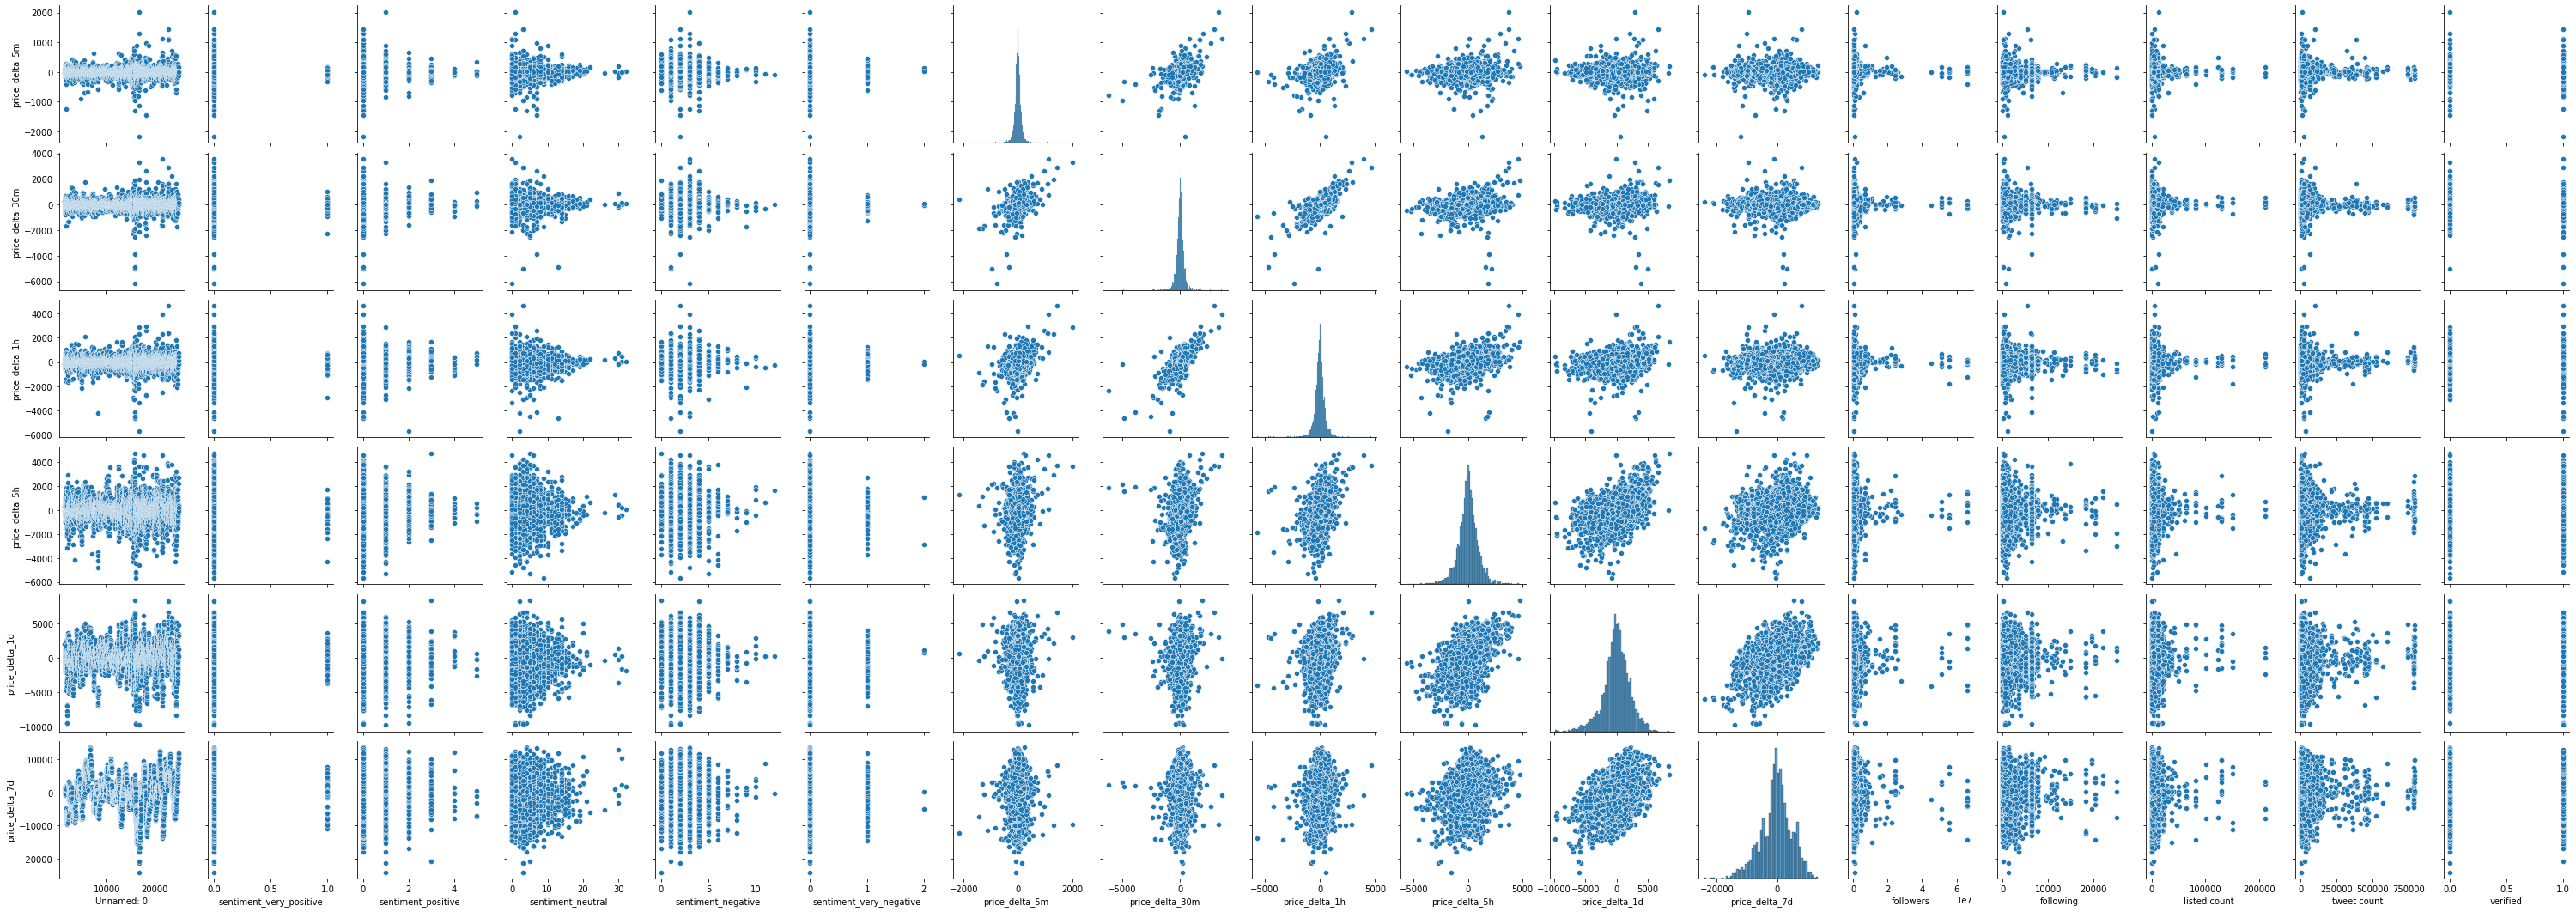

In [36]:
sns.pairplot(df_analysis,y_vars=['price_delta_5m', 'price_delta_30m', 'price_delta_1h', 'price_delta_5h', 'price_delta_1d', 'price_delta_7d'])

Como podemos ver con los graficos en x=sentiment_*, mientras más frases en el tweet, tiende a haber un menor cambio de precio, pero como podemos ver, también hay una menor cantidad de tweets mientras mayor cantidad de frases con algun sentimiento, por lo que no es una metrica que podamos utilizar directamente sin juntarla con alguna otra.

Utilizando las metricas de delta de precios, para predecir los futuros precios, solo se ve factible a corto plazo, ya que por ejemplo con el grafico de price_delta_5m vs el price_delta_7d podemos ver que la varianza de uno, no afecta **mucho** al otro.

La cantidad de followers, parece generar menos cambios en el precio mientras mayor sea el numero de seguidores, pero esto, puede ser porque estas personas tienden a ser más objetivos tratando de no interferir. Esto lo podríamos ver generando graficos con los followers y los sentimientos de los mensajes vs el delta de precios.

El following, no parece tener mucho efecto al largo plazo, lo que estaba dentro de lo esperado, aunque por otra parte, a corto plazo, se tiene un comportamiento similar al de los followers, pero esto debe pasar porque no hay suficientes mensajes.

El listed_count tiene comportamiento como el de following, lo que no era de esperarse, ya que uno pensaría que mientras más cantidad de grupos una persona pertenece, más influencial sería. Pero denuevo, no es una metrica que podamos juzgar directamente sin otras.

El tweet_count, muestra un comportamiento interesante, ya que como podemos ver, a medida que se incrementa la cantidad de tweets/persona, menor cantidad de tweets relacionados a esta investigación encontramos, pero sobre 750.000 tweets/persona encontramos un grupo que aparte de ser influyentes incluso a largo plazo (pero se necesita más información para ser concluyentes de esto), tenemos que repentinamente, tenemos una mayor cantidad de tweets recolectados. Estos, por ejemplo, pueden ser bots que anuncian noticias relacionadas al bitcoin.

Para los usuarios verificados, vemos que en 30m y 1h, hay tweets que **parecen** afectar al delta del precio en esos instantes más que los no verificados.

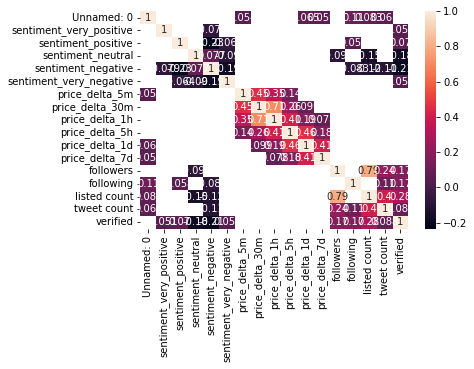

In [37]:
correlations = df_analysis.corr()
sns.heatmap(correlations[np.abs(correlations) > .05],annot=True);

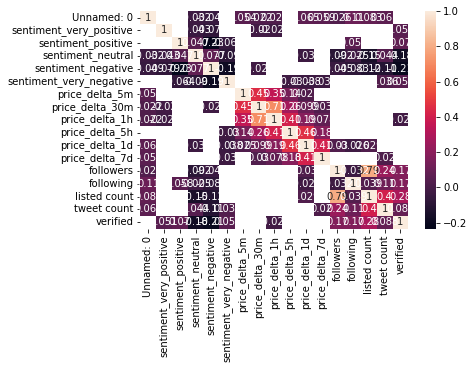

In [38]:
sns.heatmap(correlations[np.abs(correlations) > .02],annot=True);

Con el mapa de calor anterior, podemos ver que realmente no hay correlaciónes directas (significativas) entre el delta de precios y las otras variables (que no sean otros delta de precios)

Esto no significa que no tengan alguna relación, ya que un tweet de una persona que tenga muchos seguidores puede generar o no generar un cambio en el precio, pero si fue un tweet muy positivo o muy negativo, es muy probable que afecte.

Ahora que conocemos las relaciónes entre nuestras variables, podemos definir mejor cuales utilizaremos

1. Crear una función que nos permita facilmente modificar el metodo de regresión en todos lados en donde la usamos

In [39]:
def do_regression(x, y, printout=True):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 64)
    scaler = sklearn.preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # degree=3
    # poly_reg=make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree),LinearRegression())
    # poly_reg.fit(x_train,y_train)

    # ml_percep = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,10,10,20), random_state=1)
    # ml_percep.fit(x_train, y_train)

    lin_reg=LinearRegression()
    lin_reg.fit(x_train, y_train)

    y_prediction =  lin_reg.predict(x_test)
    score=r2_score(y_test,y_prediction)
    if printout:
        print(f"r2 score is {score:.4f}")
        print(f"mean_squared_error is {mean_squared_error(y_test,y_prediction):.4f}")
        print(f"root_mean_squared_error is {np.sqrt(mean_squared_error(y_test,y_prediction)):.4f}")
        #res_df = pd.DataFrame()
        #res_df["Predicted"] = y_prediction
        #res_df["Actual"] = y_test.reset_index(drop=True)
        #print(f"{res_df}%")
    return lin_reg, score

2. Usar la función para conseguir los modelos

In [40]:
df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

reg_5m, _ = do_regression(df_base_reg, df["price_delta_5m"])
reg_30m, _ = do_regression(df_base_reg, df["price_delta_30m"])
reg_1h, _ = do_regression(df_base_reg, df["price_delta_1h"])
reg_5h, _ = do_regression(df_base_reg, df["price_delta_5h"])
reg_1d, _ = do_regression(df_base_reg, df["price_delta_1d"])
reg_7d, _ = do_regression(df_base_reg, df["price_delta_7d"])

r2 score is -0.0022
mean_squared_error is 23657.1772
root_mean_squared_error is 153.8089
r2 score is -0.0045
mean_squared_error is 151014.6562
root_mean_squared_error is 388.6060
r2 score is -0.0084
mean_squared_error is 253667.2772
root_mean_squared_error is 503.6539
r2 score is -0.0088
mean_squared_error is 879898.9397
root_mean_squared_error is 938.0293
r2 score is 0.0093
mean_squared_error is 4203269.2935
root_mean_squared_error is 2050.1876
r2 score is -0.0037
mean_squared_error is 26956305.8862
root_mean_squared_error is 5191.9463


Como podemos ver, la regresión, no está nada de cerca, (Ridge y lasso no fueron muy diferentes. Cambiar variables x, tampoco ayudó)


Por tanto, vamos a tener que cambiar nuestra mirada e intentar hacer clustering, para ver si el precio sube o baja, y así alivianar la carga del modelo.

1. Crear un dataframe con los datos como categorias

In [41]:
df_cluster_values = df[["price_delta_5m","price_delta_30m","price_delta_1h","price_delta_5h","price_delta_1d","price_delta_7d"]]
for col in df_cluster_values.columns:
    df_cluster_values.loc[df_cluster_values[col] >= 0, col] = 1
    df_cluster_values.loc[df_cluster_values[col] < 0, col] = 0
    # Cambiamos primero a int64 para eliminar el punto decimal
    df_cluster_values[col] = df_cluster_values[col].astype("int64").astype("category")

2. Crear una función que nos permita facilmente modificar el metodo de regresión en todos lados en donde la usamos

In [42]:
def do_clustering(x, y, printout=True):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.25,random_state = 64)

    scaler = sklearn.preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    cluster_clas = KNeighborsClassifier(3)
    cluster_clas.fit(x_train, y_train)

    y_prediction =  cluster_clas.predict(x_test)
    score = r2_score(y_test,y_prediction)

    if printout:
        print(f"r2 score is {score:.4f}")
        print(f"mean_squared_error is {mean_squared_error(y_test,y_prediction):.4f}")
        print(f"root_mean_squared_error is {np.sqrt(mean_squared_error(y_test,y_prediction)):.4f}")
        print(f"{(len(y_prediction[y_prediction == y_test])/len(y_prediction)*100):.3}% are correct cases")
    return cluster_clas, score

3. Usar la función para conseguir los modelos

In [43]:
df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

clus_5m, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_5m"])
clus_30m, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_30m"])
clus_1h, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_1h"])
clus_5h, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_5h"])
clus_1d, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_1d"])
clus_7d, _ = do_clustering(df_base_reg, df_cluster_values["price_delta_7d"])


r2 score is -1.0087
mean_squared_error is 0.5022
root_mean_squared_error is 0.7086
49.8% are correct cases
r2 score is -1.0032
mean_squared_error is 0.5004
root_mean_squared_error is 0.7074
50.0% are correct cases
r2 score is -1.0000
mean_squared_error is 0.4987
root_mean_squared_error is 0.7062
50.1% are correct cases
r2 score is -0.9477
mean_squared_error is 0.4866
root_mean_squared_error is 0.6976
51.3% are correct cases
r2 score is -0.8540
mean_squared_error is 0.4634
root_mean_squared_error is 0.6807
53.7% are correct cases
r2 score is -0.7347
mean_squared_error is 0.4324
root_mean_squared_error is 0.6576
56.8% are correct cases


Ninguno de los 3 modelos que podríamos usar para este proyecto ya sea regresión o clustering (también probamos modelos de clasificación supervisada y de multi-layer perceptron, pero no dieron un mejor resultado en ni en clasificación o regresión) logró hacer una predicción cercana a lo esperado (O mejor que lanzar una moneda al aire en caso de los de clasificación)

Si tuvieramos más tiempo, nos habría gustado filtrar menos tweets, pero por problemas de tiempo tuvimos que eliminar muchos para que el sentiment analysis no se demorara tanto. De todas formas, es muy probable que nos habría pasado lo mismo. También nos habria gustado hacer una red neuronal más compleja con TensorFlow, para ver si existe un comportamiento complejo con las variables seleccionadas, que no logramos encontrar.

Tratando de reducir las variables, podemos filtrar por un solo usuario, (En este caso DocumentingBTC, que tiene la mayor cantidad de tweets)

In [44]:
df_dbtc = df[df["p_id"] == "DocumentingBTC"]

df_analysis = df_dbtc.copy(deep=True)

followers = []
following = []
listed_count = []
tweet_count = []
verified = []

p_len = len(df_dbtc)
for u_id, user in enumerate(df_dbtc.iloc):
    print(f"{u_id+1}/{p_len}\r", end="")
    usr = df_users[df_users["username"] == user["p_id"]].iloc[0]
    followers.append(usr["followers"])
    following.append(usr["following"])
    listed_count.append(usr["listed count"])
    tweet_count.append(usr["tweet count"])
    verified.append(usr["verified"])

df_analysis["followers"] = followers
df_analysis["following"] = following
df_analysis["listed count"] = listed_count
df_analysis["tweet count"] = tweet_count
df_analysis["verified"] = verified

df_analysis = df_analysis.drop(["p_id", "date", "tweet", "sentiment_begin", "sentiment_end"], axis="columns", )

df_base_reg = df_analysis.copy(deep=True)
df_base_reg = df_base_reg.drop(["price_delta_5m", "price_delta_30m", "price_delta_1h", "price_delta_5h", "price_delta_1d", "price_delta_7d"], axis="columns")

df_ccols = ["price_delta_5m","price_delta_30m","price_delta_1h","price_delta_5h","price_delta_1d","price_delta_7d"]
for col in df_ccols:
    df_dbtc.loc[df_dbtc[col] >= 0, col] = 1
    df_dbtc.loc[df_dbtc[col] < 0, col] = 0
    df_dbtc[col] = df_dbtc[col].astype("int64").astype("category")

reg_5m, _ = do_clustering(df_base_reg, df_dbtc["price_delta_5m"])
reg_30m, _ = do_clustering(df_base_reg, df_dbtc["price_delta_30m"])
reg_1h, _ = do_clustering(df_base_reg, df_dbtc["price_delta_1h"])
reg_5h, _ = do_clustering(df_base_reg, df_dbtc["price_delta_5h"])
reg_1d, _ = do_clustering(df_base_reg, df_dbtc["price_delta_1d"])
reg_7d, _ = do_clustering(df_base_reg, df_dbtc["price_delta_7d"])

r2 score is -0.9180
mean_squared_error is 0.4773
root_mean_squared_error is 0.6908
52.3% are correct cases
r2 score is -0.9091
mean_squared_error is 0.4773
root_mean_squared_error is 0.6908
52.3% are correct cases
r2 score is -1.1768
mean_squared_error is 0.5341
root_mean_squared_error is 0.7308
46.6% are correct cases
r2 score is -0.7600
mean_squared_error is 0.4318
root_mean_squared_error is 0.6571
56.8% are correct cases
r2 score is -0.7499
mean_squared_error is 0.4318
root_mean_squared_error is 0.6571
56.8% are correct cases
r2 score is -0.4098
mean_squared_error is 0.3523
root_mean_squared_error is 0.5935
64.8% are correct cases


Pero tampoco nos entrega buenos resultados

Podemos intentar revisando solo los tweets con mayor sentimiento positivo que negativo

Otra alternativa es buscar si hay una corelación entre **cantidad** de tweets y la variación del precio

1. Crear un dataframe con los valores necesarios

In [45]:
df_tweets = pd.DataFrame()
df_tweets["date"] = df["date"]
df_tweets["followers"] = df_analysis["followers"]


Vamos a separar los tweets por cantidad de seguidores
1. followers < 3.213670e+05
2. 3.213670e+05 < followers < 6.631780e+05
3. 6.631780e+05 < followers < 1.369842e+06
4. followers >= 1.369842e+06
5. cualquier cantidad de seguidores


In [46]:
tweet_first_tm = datetime.fromtimestamp(np.min(df["date"]))
tweet_last_tm = datetime.fromtimestamp(np.max(df["date"]))

current_day = datetime(tweet_first_tm.year, tweet_first_tm.month, tweet_first_tm.day)
end_day = datetime(tweet_last_tm.year, tweet_last_tm.month, tweet_last_tm.day)

date_tab = []
price_tab = []

while current_day < end_day:
    next_day = current_day + timedelta(days=1)
    date_tweets = df_tweets[df_tweets["date"] >= current_day.timestamp()]
    date_tweets = date_tweets[date_tweets["date"] < next_day.timestamp()]

    price_day = df_btc[df_btc["timestamp"] > current_day.timestamp()]
    price_day = price_day[price_day["timestamp"] < next_day.timestamp()]["price"]

    date_tab.append([current_day.timestamp(), next_day.timestamp(),
                     len(date_tweets[date_tweets["followers"] < 3.213670e+05]),
                     len(date_tweets[(date_tweets["followers"] < 6.631780e+05) & (date_tweets["followers"] >= 3.213670e+05)]),
                     len(date_tweets[(date_tweets["followers"] < 1.369842e+06) & (date_tweets["followers"] >= 6.631780e+05)]),
                     len(date_tweets[date_tweets["followers"] >= 1.369842e+06]),
                     len(date_tweets)])
    price_tab.append([price_day.iloc[0],
                      price_day.iloc[-1],
                      price_day.iloc[-1] - price_day.iloc[0],
                      np.abs(price_day.iloc[-1] - price_day.iloc[0]),
                      1 if price_day.iloc[-1] > price_day.iloc[0] else 0])

    current_day = next_day
df_follows = pd.DataFrame(date_tab, columns=["start_date", "end_date", "follow_1", "follow_2", "follow_3", "follow_4", "follow_5"])
df_t_prices = pd.DataFrame(price_tab, columns=["price_start", "price_end", "price_delta", "price_delta_abs", "increment"])

2) Transformar el valor de incremento a categoria para poder hacer clustering

In [47]:
df_t_prices["increment"] = df_t_prices["increment"].astype("category")

3) Analizar la correlación entre variables

<AxesSubplot:>

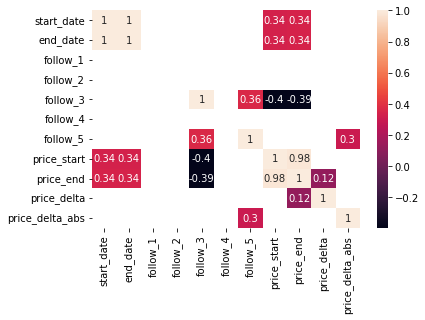

In [48]:
mx = pd.concat([df_follows, df_t_prices], axis=1)
hm = mx.corr()
sns.heatmap(hm[np.abs(hm)>0.1], annot=True)

Podemos ver que follow_5 (todos los tweets sin importar los seguidores que tenga el usuario que posteo) tiene una corelación con el valor absoluto del cambio de precio diario

<AxesSubplot:xlabel='follow_5', ylabel='price_delta_abs'>

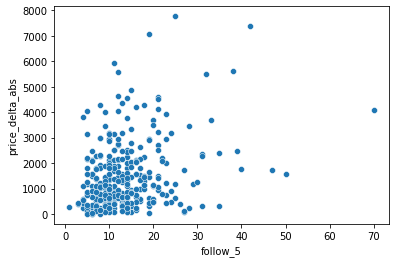

In [49]:
sns.scatterplot('follow_5', 'price_delta_abs', data=mx)

Como podemos ver, efectivamente tiende a haber una correlación la cantidad de tweets y el cambio en el precio, mientras más tweets existan, más tiende a cambiar el precio.

Lamentablemente, también podemos ver que aunque hay una tendencia, los valores no la siguen de muy cerca, por lo que aunque podemos predecir, vamos a tener un alto grado de error. Si tuviesemos tweets con fechas anteriores, podríamos tener una mayor presición y a lo mejor, veríamos que realmente, es bastante certero apesar de el gran error en esta muestra pequeña.

Por esta razón, podemos igual hacer un modelo y hacer alguna predicciónes para revisar en el futuro.

In [50]:
price_delta, _ = do_regression(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["price_delta"])

r2 score is -0.0485
mean_squared_error is 3531655.7330
root_mean_squared_error is 1879.2700


In [51]:
price_delta_abs, _ = do_regression(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["price_delta_abs"])

r2 score is 0.0507
mean_squared_error is 1323144.7485
root_mean_squared_error is 1150.2803


In [52]:
incr, _ = do_clustering(df_follows.drop(["start_date", "end_date"], axis="columns"), df_t_prices["increment"])

r2 score is -0.9789
mean_squared_error is 0.4941
root_mean_squared_error is 0.7029
50.6% are correct cases


Aunque de los 3, el menor r2 es el regresión para price_delta, decidimos elegir el menor error_cuadratico_medio, es decir, el que predice el valor absoluto de el cambio en el precio.


Como tenemos el modelo en la variable price_delta_abs, podemos hacer nuestras predicciónes

In [56]:

# Cada linea es una predición en el mismo formato que decidimos al separar los tweets por seguidores
pred = [
    [20, 35, 62, 65, 70],
    [30, 40, 69, 75, 85],
    [51, 67, 79, 91, 100]
]

price_delta_abs.predict(pd.DataFrame(pred))

array([27815.78726291, 34159.84332477, 40172.71901336])

Como podemos ver, el modelo nos entrega valores para las predicciónes dependiendo de los parametros que elijamos, pero como los datos no están muy alineados, no es certero segun los datos que tenemos

Al final, pudimos observar que la connotación del tweet no tiene casí nada de relación con los cambios en el valor del bitcoin ya que no solo teníanm poca correlación en el mapa de calor sino que también sí habían opiniones negativas y positivas pero las que afectaban más eran las opiniones neutrales (Esto asociado también al hecho de que están acumulados los tweets en lo neutro en uno de los graficos y claramente es cuando se ve más afectado), lo mismo ocurre con la cantidad de followers (o popularidad) de la cuenta con el precio, tiene poca correlación con el valor de Bitcoin. Pero eso sí, pudimos detectar que efectivamente encontramos una gran correlación entre el valor del bitcoin y el número de tweets que se publicaron en tiempos parecidos hablando sobre el bitoin.
En cuanto a la última pregunta, como no pudimos construir un modelo que no tuviera un valor alto de r2 no podemos responderla ya que se requiriría predecir